# 🧠 Computer Vision with Pre-trained Models

This notebook demonstrates how to use pre-trained models for common computer vision tasks:
- **Classification** (with `timm`)
- **Object Detection** (with YOLOv8)
- **Segmentation** (with DeepLabV3 and SAM)
- **OCR** (with TrOCR and pytesseract)

We will also discuss limitations and show how to fine-tune a classifier on custom data.

## 1. Image Classification with `timm`

Let's classify an image using a pre-trained ResNet-50 from [timm](https://github.com/rwightman/pytorch-image-models).

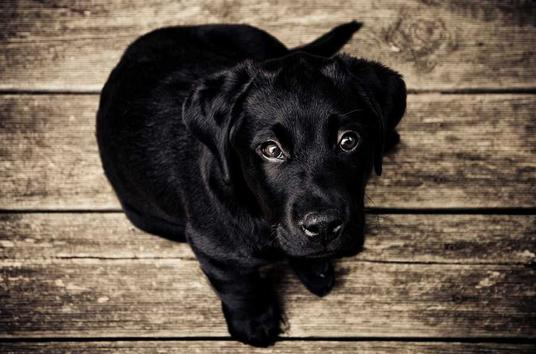

Predicted: Labrador retriever


In [3]:
import timm
import torch
from PIL import Image
from torchvision import transforms
import requests
from io import BytesIO
from IPython.display import display

# Download an example image (dog)
url = 'https://fastly.picsum.photos/id/237/536/354.jpg?hmac=i0yVXW1ORpyCZpQ-CknuyV-jbtU7_x9EBQVhvT5aRr0'
img = Image.open(BytesIO(requests.get(url).content)).convert('RGB')
display(img)  # Shows image inline in the notebook

# Preprocess
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = transform(img).unsqueeze(0)

# Load model
model = timm.create_model('resnet50', pretrained=True)
model.eval()

# Predict
with torch.no_grad():
    out = model(input_tensor)
    pred = out.argmax(dim=1).item()

# Get class labels
labels = requests.get('https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt').text.splitlines()
print(f'Predicted: {labels[pred]}')

## 2. Object Detection with YOLOv8

Detect objects in an image using [YOLOv8](https://docs.ultralytics.com/).


0: 448x640 1 dog, 40.7ms
Speed: 2.8ms preprocess, 40.7ms inference, 3.5ms postprocess per image at shape (1, 3, 448, 640)


'1 dog, '

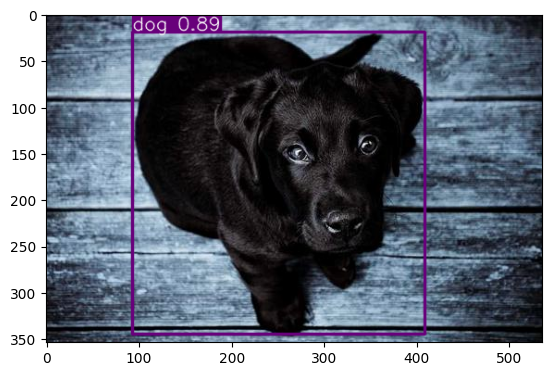

In [4]:
# !pip install ultralytics --quiet
from matplotlib import pyplot as plt
from ultralytics import YOLO

yolo_model = YOLO('yolov8n.pt')  # nano model for speed

# Use the PIL image loaded earlier (img)
results = yolo_model(img)
# YOLO returns a list of Results; use the first element
# results[0].show()      # displays image with boxes
plt.imshow(results[0].plot())  # Shows detection result inline
results[0].verbose()   # prints detection details

## 3. Image Segmentation with DeepLabV3

Segment objects in the image using DeepLabV3 from torchvision.

/Users/aguschin/Library/Caches/pypoetry/virtualenvs/echobot-Fhr7ANK2-py3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/aguschin/Library/Caches/pypoetry/virtualenvs/echobot-Fhr7ANK2-py3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


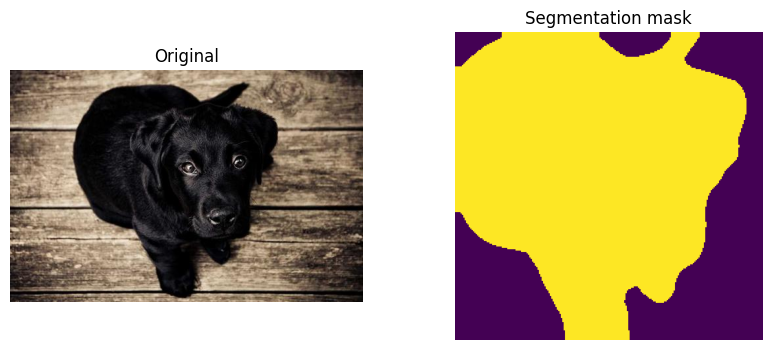

In [5]:
import torchvision
deeplab = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True).eval()

seg_input = transform(img).unsqueeze(0)
with torch.no_grad():
    output = deeplab(seg_input)['out'][0]
mask = output.argmax(0)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(mask)
plt.title('Segmentation mask')
plt.axis('off')
plt.show()

> **Note:** For advanced segmentation and interactive masks, see [Meta's Segment Anything Model (SAM)](https://github.com/facebookresearch/segment-anything).

## 4. OCR: Text Extraction with TrOCR and pytesseract

Let's extract text from an image using both pytesseract and TrOCR. Try with a real image containing text for best results.

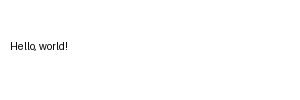

pytesseract OCR: Hella world!


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Keyword argument `use_fast` is not a valid argument for this processor and will be ignored.


TrOCR OCR: Helloworldt .


In [6]:
# !pip install pytesseract transformers --quiet
import pytesseract
from PIL import ImageDraw, ImageFont

# Create a simple image with text for demo
img_text = Image.new('RGB', (300, 100), color = (255,255,255))
d = ImageDraw.Draw(img_text)
d.text((10,40), "Hello, world!", fill=(0,0,0))
display(img_text)

ocr_text = pytesseract.image_to_string(img_text)
print('pytesseract OCR:', ocr_text.strip())

from transformers import TrOCRProcessor, VisionEncoderDecoderModel
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten')
pixel_values = processor(images=img_text, return_tensors="pt", use_fast=True).pixel_values
generated_ids = model.generate(pixel_values)
ocr_text2 = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print('TrOCR OCR:', ocr_text2.strip())

## 5. Limitations of Pre-trained CV Models

- Poor performance on medical, satellite, or custom images
- Limited to classes seen during pre-training
- May require fine-tuning for domain-specific tasks

Try running the classifier on a medical or satellite image to see the limitations.

## 6. Fine-tuning a Classifier on Custom Data

Example: fine-tuning a ResNet on a small custom dataset using PyTorch Lightning or HuggingFace `Trainer`.

> See [timm transfer learning docs](https://rwightman.github.io/pytorch-image-models/transfer_learning/) for details.
